# Learning from an optimization perspective

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.optimize import fsolve
import time as time

In [107]:
import algos_QP
from RandomWalk import Random_walk

In [108]:
reload(algos_QP)
reload(RandomWalk)

<module 'RandomWalk' from 'RandomWalk.pyc'>

# 1. Online algorithms

In [48]:
nState=1000
nStep=100
nFeatures=100
gamma=0.9

P_pi,r_pi=Random_walk.compute_policy(nState,nStep)

d_init=(1.0/nState)*np.ones(nState+1)
d_init[0]=0.0
problem=Random_walk(gamma,nState,nState+1,P_pi,d_init)

In [935]:
nIter=25000

algos=['LLSTD' for i in range(1)]
#algos.append('LSTD')
algos=['TD','TDC','TDC','LSTD']


nAlgos=len(algos)
com=['' for i in range(nAlgos)]

zeta=0.0*np.ones(nAlgos)
alpha=0.01*np.ones(nAlgos)
beta=0.05*np.ones(nAlgos)
#beta[2]=0.1
gamma=0.9*np.ones(nAlgos)
momentum=['None' for i in range(nAlgos)]
momentum[2]='Regular'
com[2]='+Adaptive Momentum'
#momentum[4]=True

theta=np.zeros((nAlgos,nIter+1,problem.nFeatures+1))

for algo in range(nAlgos):
    problem.restart()
    np.random.seed(0)
    theta[algo,:]=problem.run_algo(algos[algo],nIter,verbose=True,
                                   alpha_=alpha[algo],beta_=beta[algo], gamma_=gamma[algo],zeta_=zeta[algo],
                                   momentum=momentum[algo],
                                   epsilon_LSTD=1.)

Algo: TD 	 | Time (s): 0.855705266542
Algo: TDC 	 | Time (s): 1.00233738769
Algo: TDC 	 | Time (s): 0.957858074809
Algo: LSTD 	 | Time (s): 2.14705724127


In [936]:
#compute value function
v=np.zeros((nAlgos,nIter+1,problem.nState+1))
for algo in range(nAlgos):
    v[algo,:]=((problem.Phi).dot(theta[algo,:].T)).T

#compute true TD fixed point
theta_TD_star = np.linalg.inv(problem.A_approx).dot(problem.b_approx)
v_TD_star = (problem.Phi).dot(theta_TD_star)

#compute history of MSVE
MSVE=np.zeros((nAlgos,nIter+1))
for algo in range(nAlgos):
    MSVE[algo,:]=np.sum((problem.d_stationnary)*(v[algo,:]-v_TD_star)*(v[algo,:]-v_TD_star),1)

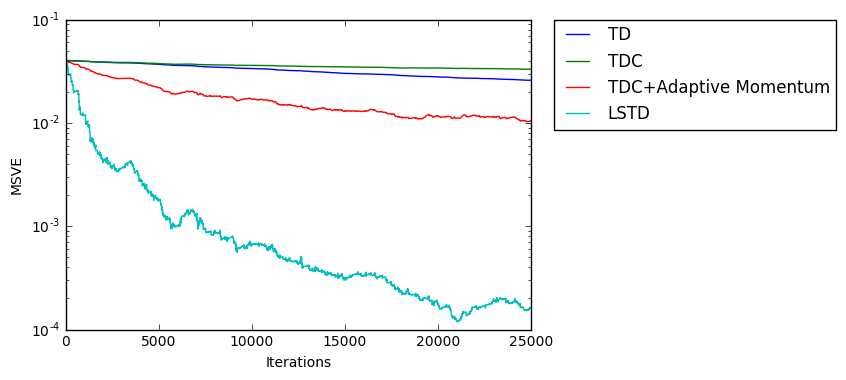

In [937]:
for algo in range(nAlgos):
    plt.semilogy(MSVE[algo,:],label=algos[algo]+com[algo])
    
#plt.semilogy(MSVE[nAlgos-1,:],label=algos[algo]+' - g='+str(gamma[algo]),color='r',lw=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Iterations')
plt.ylabel('MSVE')
#plt.axis([0,25000,0.01,0.2])
#plt.savefig('C:\Users\Mathieu\Dropbox\PolyMTL\Cours\COMP762 - Reinforcement Learning\Project\Presentation\images\Gradient_TD.png', bbox_inches='tight')

plt.show()

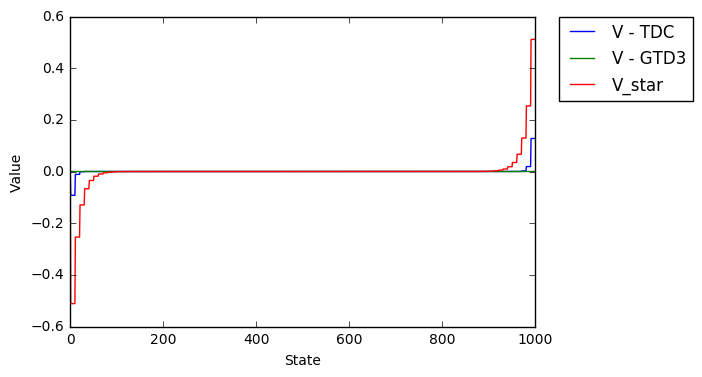

In [665]:
#plot the learned value functions
#plot the learning curves
for algo in range(nAlgos):
    plt.plot(v[algo,nIter,:],label='V - '+algos[algo])

plt.plot(v_TD_star,label='V_star')
plt.xlabel('State')
plt.ylabel('Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## 2.2 Tabular representation

In [130]:
reload(algos_QP)
reload(RandomWalk)

<module 'RandomWalk' from 'RandomWalk.pyc'>

In [131]:
nState=1000
nStep=100
nFeatures=100
gamma=0.9

P_pi,r_pi=Random_walk.compute_policy(nState,nStep)

d_init=(1.0/nState)*np.ones(nState+1)
d_init[0]=0.0
problem=Random_walk(gamma,nState,nState+1,P_pi,d_init)

In [133]:
#First, compute value function in the tabular case
nIter=250
history=True

algos=['DP','CG']

nAlgos=len(algos)
t_algo=np.zeros(nAlgos)
nIter_algo=np.zeros(nAlgos)

v_init=None

if(history):
    v=np.zeros((nAlgos,nIter+1,problem.nState+1)) 
else:
    v=np.zeros((nAlgos,problem.nState+1))

for algo in range(nAlgos):
    n,t,v_res=algos_QP.compute_valueFunction(
        P_pi,r_pi,gamma,
        algos[algo],nIter,x_init_=v_init,
        verbose=True,history=history,preconditionner=False)

    v[algo,:]=v_res
    t_algo[algo]=t
    nIter_algo[algo]=n


#To compute the errors, we need to know the true value of v_TD
#Any method can be used, here we just take the value returned by CG
n,t,v_TD = algos_QP.compute_valueFunction(
        P_pi,r_pi,gamma,
        algo='Newton',nIter_max=nIter,verbose=True,history=False)

print '\n\n'

#Now, compute errors
if(history):
    err=np.zeros((nAlgos,nIter+1))
    for algo in range(nAlgos):
        err[algo,:]=np.max(np.abs(v[algo,:]-v_TD),1)

else:
    for algo in range(nAlgos):
        print 'Algo:',algos[algo], '\t | final error:', np.max(np.abs(v[algo]-v_TD))
        

Algo: DP 	 | Time (s): 0.0521958163208 	 | #Iter: 176 	 | T/iter: 0.000296567138186
Algo: CG 	 | Time (s): 0.0131867703767 	 | #Iter: 23 	 | T/iter: 0.000573337842465
Algo: Newton 	 | Time (s): 0.0392177414014 	 | #Iter: 1 	 | T/iter: 0.0392177414014





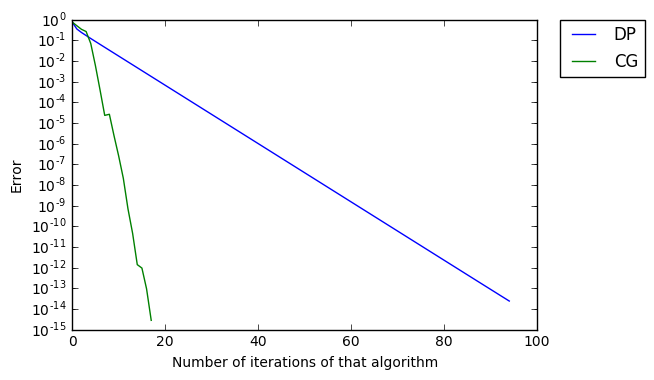

In [114]:
#plot the learning curves
plot_time=False

for algo in range(nAlgos):
    if(plot_time):
    
        plt.semilogy((t_algo[algo]/nIter_algo[algo])*np.arange(nIter_algo[algo]+1),err[algo,range(int(nIter_algo[algo]+1))],label=algos[algo])
        plt.xlabel('Running time (s)')
    else:
        plt.semilogy(np.arange(nIter_algo[algo]+1),err[algo,range(int(nIter_algo[algo]+1))],label=algos[algo])
        plt.xlabel('Number of iterations of that algorithm')
    
plt.ylabel('Error')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#plt.savefig('C:\Users\Mathieu\Dropbox\PolyMTL\Cours\COMP762 - Reinforcement Learning\Project\Presentation\images\DP_QP.png', bbox_inches='tight')
plt.show()

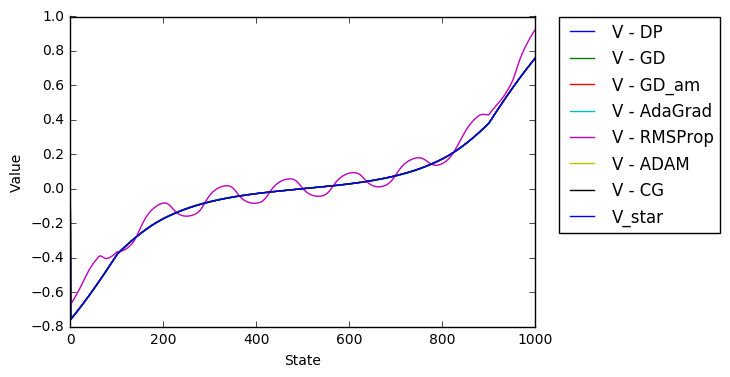

In [84]:
#plot the learned value functions
#plot the learning curves
for algo in range(nAlgos):
    plt.plot(v[algo,nIter,:],label='V - '+algos[algo])


plt.plot(v_TD,label='V_star')
plt.xlabel('State')
plt.ylabel('Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## 2.3 Linear approximation

In [ ]:
#First, compute the optimal parameter vector, theta
nIter=10000
history=True

algos=['DP','CG']
algos=['DP','GD','GD_am','GD_ADAM','CG']

nAlgos=len(algos)


#compute theta
if(history):
    theta_history=np.zeros((nAlgos,nIter+1,problem.nFeatures+1))
    v_history=np.zeros((nAlgos,nIter+1,problem.nState+1)) 
    for algo in range(nAlgos):
        theta_history[algo,:]=problem.compute_valueFunction_approx(algos[algo],nIter,alpha=1.0,
                                                                   verbose=True,history=history,preconditionner=False)
        v_history[algo,:]=((problem.Phi).dot(theta_history[algo,:].T)).T
else:
    theta=np.zeros((nAlgos,problem.nFeatures+1))
    v=np.zeros((nAlgos,problem.nState+1))
    for algo in range(nAlgos):
        theta[algo,:]=problem.compute_valueFunction_approx(algos[algo],nIter,alpha=1.0,
                                                           verbose=True,history=history,preconditionner=False)
        v[algo,:]=(problem.Phi).dot(theta[algo,:]).T



#To compute the errors, we need to know the true value of v_TD
start=time.clock()
theta_TD = np.linalg.inv(problem.A_approx).dot(problem.b_approx)
v_TD = (problem.Phi).dot(theta_TD)
problem.theta=theta_TD
print 'Algo: Newton \t | Time (s):', time.clock()-start
print '\n\n'

#Now, compute errors
if(history):
    err_history=np.zeros((nAlgos,nIter+1))
    for algo in range(nAlgos):
        err_history[algo,:]=np.max(np.abs(v_history[algo,:]-v_TD),1)

else:
    for algo in range(nAlgos):
        print 'Algo:',algos[algo], '\t | final error:', np.max(np.abs(v[algo]-v_TD))

In [ ]:
#plot the learning curves
for algo in range(nAlgos):
    plt.semilogy(err_history[algo,:],label='Error - '+algos[algo])

plt.xlabel('Number of iterations of that algorithm')
plt.ylabel('Error')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
#plot the learned value functions
#plot the learning curves
for algo in range(nAlgos):
    plt.plot(v_history[algo,nIter,:],label='V - '+algos[algo])


plt.plot(v_TD,label='V_star')
plt.xlabel('State')
plt.ylabel('Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Example in one dimension